In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, relu=True, **kwargs):
        super(BasicConv2d, self).__init__()
        self.relu = relu
        if self.relu:
            self.feature = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.feature = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
            )

    def forward(self, x):
        out = self.feature(x)
        return out

In [8]:
class ShuffleBlock(nn.Module):
    def __init__(self, num_groups):
        super(ShuffleBlock, self).__init__()
        self.num_groups = num_groups

    def forward(self, x):
        out = self.shuffle_channel(x, self.num_groups)
        return out
    
    def shuffle_channel(self, x, num_groups):
        batch_size, num_channels, height, width = x.size()
        assert num_channels % num_groups == 0

        x = x.view(batch_size, num_groups, num_channels // self.num_groups, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        return x.contiguous().view(batch_size, num_channels, height, width)

In [9]:
class ShuffleUnit(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, stride):
        super(ShuffleUnit, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bottleneck_channel = in_channels//4
        self.num_groups = num_groups
        self.stride = stride
        self.shuffle_unit = self._make_shuffle_unit(stride=self.stride)

    def forward(self, x):
        residual = x
        if self.stride == 1:
            return F.relu(input=(residual+self.shuffle_unit(x)), inplace=True)
        elif self.stride == 2:
            residual = F.avg_pool2d(
                input=residual, kernel_size=3, stride=2, padding=1)
            out = self.shuffle_unit(x)
            out = torch.cat((residual, out), dim=1)
            return F.relu(input=out, inplace=True)

    def _make_shuffle_unit(self, stride):
        shuffle_unit = nn.Sequential(
            BasicConv2d(in_channels=self.in_channels, out_channels=self.bottleneck_channel, relu=True,
                        kernel_size=1, stride=1, padding=0, groups=self.num_groups),
            ShuffleBlock(num_groups=self.num_groups),
            BasicConv2d(in_channels=self.bottleneck_channel, out_channels=self.bottleneck_channel,
                        relu=False, kernel_size=3, stride=stride, padding=1, groups=self.bottleneck_channel),
            BasicConv2d(in_channels=self.bottleneck_channel, out_channels=self.out_channels, relu=False,
                        kernel_size=1, stride=1, padding=0, groups=self.num_groups),
        )
        return shuffle_unit

In [10]:
class ShuffleNetV1(nn.Module):
    def __init__(self, ong, num_classes=10):
        super(ShuffleNetV1, self).__init__()
        self.in_channels = 24
        self.out_channels = ong['out_channels']
        self.num_blocks = ong['num_blocks']
        self.num_groups = ong['num_groups']

        self.stage1 = nn.Sequential(
            BasicConv2d(in_channels=3, out_channels=24, relu=True,
                        kernel_size=3, stride=2, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.stage2 = self._make_layer(
            out_channels=self.out_channels[0], num_blocks=self.num_blocks[0], num_groups=self.num_groups)
        self.stage3 = self._make_layer(
            out_channels=self.out_channels[1], num_blocks=self.num_blocks[1], num_groups=self.num_groups)
        self.stage4 = self._make_layer(
            out_channels=self.out_channels[2], num_blocks=self.num_blocks[2], num_groups=self.num_groups)
        self.globalpool = nn.AvgPool2d(kernel_size=7)
        self.fc = nn.Linear(
            in_features=self.out_channels[2], out_features=num_classes)

    def _make_layer(self, out_channels, num_blocks, num_groups):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ShuffleUnit(in_channels=self.in_channels,
                                          out_channels=out_channels-self.in_channels,
                                          num_groups=num_groups, stride=2))
            else:
                layers.append(ShuffleUnit(in_channels=self.in_channels,
                                          out_channels=out_channels,
                                          num_groups=num_groups, stride=1))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stage1(x)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.globalpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [11]:
def ShuffleNetV1G1(num_classes=10):
    ong = {
        'out_channels': [144, 288, 576],
        'num_blocks': [3, 7, 3],
        'num_groups': 1
    }
    return ShuffleNetV1(ong, num_classes)


def ShuffleNetV1G2(num_classes=10):
    ong = {
        'out_channels': [200, 400, 800],
        'num_blocks': [3, 7, 3],
        'num_groups': 2
    }
    return ShuffleNetV1(ong, num_classes)


def ShuffleNetV1G3(num_classes=10):
    ong = {
        'out_channels': [240, 480, 960],
        'num_blocks': [3, 7, 3],
        'num_groups': 3
    }
    return ShuffleNetV1(ong, num_classes)

In [12]:
net = ShuffleNetV1G2().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
       BasicConv2d-4         [-1, 24, 112, 112]               0
         MaxPool2d-5           [-1, 24, 56, 56]               0
            Conv2d-6            [-1, 6, 56, 56]              78
       BatchNorm2d-7            [-1, 6, 56, 56]              12
              ReLU-8            [-1, 6, 56, 56]               0
       BasicConv2d-9            [-1, 6, 56, 56]               0
     ShuffleBlock-10            [-1, 6, 56, 56]               0
           Conv2d-11            [-1, 6, 28, 28]              60
      BatchNorm2d-12            [-1, 6, 28, 28]              12
      BasicConv2d-13            [-1, 6, 28, 28]               0
           Conv2d-14          [-1, 176,

In [15]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [16]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [17]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [18]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [19]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [20]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.557536
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.037962
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.753491
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.688367
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.636806
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.483315
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.867086
VAL set: Average loss: 0.028201, Accuracy: 3516.0/10000 (35.2%)
Validation loss decreased (inf --> 0.028201).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.505983
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.555484
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.449379
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.385437
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.467344
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.246552
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.550946
VAL set: Average loss: 0.026351, Accuracy: 4189.0/10000 (41.9%)
Validation loss decreased (0.028201 --> 0.026351).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.731524
Trai

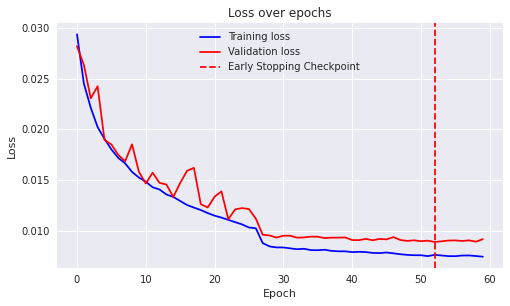

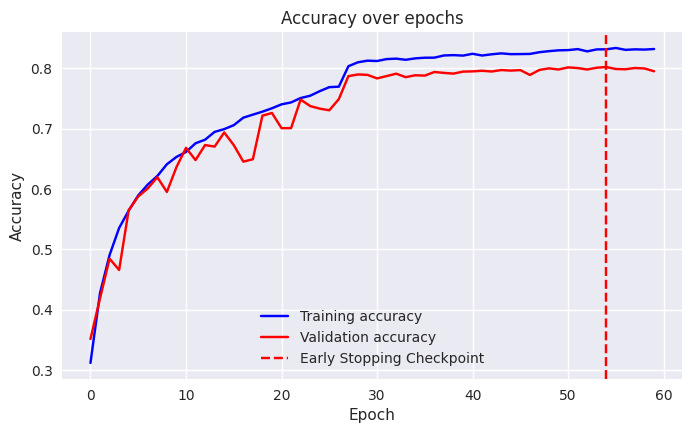

In [21]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'ShuffleNetV1 - predictions')

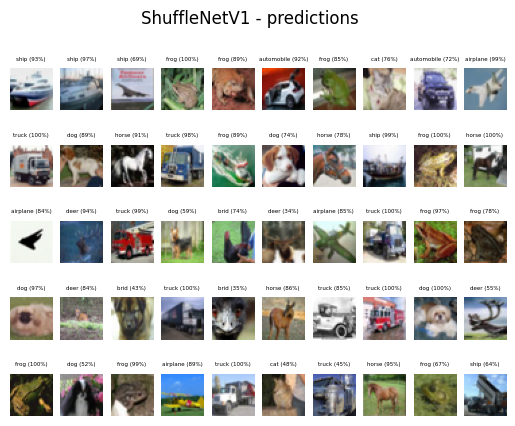

In [22]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('ShuffleNetV1 - predictions')

In [ ]:
"""
ShuffleNet
Mine(batch_size = 32):
After 20 Epoch: 67.0%
After 40 Epoch: 78.8%
After 59 Epoch: 79.4%
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
       BasicConv2d-4         [-1, 24, 112, 112]               0
         MaxPool2d-5           [-1, 24, 56, 56]               0
            Conv2d-6            [-1, 6, 56, 56]              78
       BatchNorm2d-7            [-1, 6, 56, 56]              12
              ReLU-8            [-1, 6, 56, 56]               0
       BasicConv2d-9            [-1, 6, 56, 56]               0
     ShuffleBlock-10            [-1, 6, 56, 56]               0
           Conv2d-11            [-1, 6, 28, 28]              60
      BatchNorm2d-12            [-1, 6, 28, 28]              12
      BasicConv2d-13            [-1, 6, 28, 28]               0
           Conv2d-14          [-1, 176, 28, 28]             704
      BatchNorm2d-15          [-1, 176, 28, 28]             352
      BasicConv2d-16          [-1, 176, 28, 28]               0
      ShuffleUnit-17          [-1, 200, 28, 28]               0
           Conv2d-18           [-1, 50, 28, 28]           5,050
      BatchNorm2d-19           [-1, 50, 28, 28]             100
             ReLU-20           [-1, 50, 28, 28]               0
      BasicConv2d-21           [-1, 50, 28, 28]               0
     ShuffleBlock-22           [-1, 50, 28, 28]               0
           Conv2d-23           [-1, 50, 28, 28]             500
      BatchNorm2d-24           [-1, 50, 28, 28]             100
      BasicConv2d-25           [-1, 50, 28, 28]               0
           Conv2d-26          [-1, 200, 28, 28]           5,200
      BatchNorm2d-27          [-1, 200, 28, 28]             400
      BasicConv2d-28          [-1, 200, 28, 28]               0
      ShuffleUnit-29          [-1, 200, 28, 28]               0
           Conv2d-30           [-1, 50, 28, 28]           5,050
      BatchNorm2d-31           [-1, 50, 28, 28]             100
             ReLU-32           [-1, 50, 28, 28]               0
      BasicConv2d-33           [-1, 50, 28, 28]               0
     ShuffleBlock-34           [-1, 50, 28, 28]               0
           Conv2d-35           [-1, 50, 28, 28]             500
      BatchNorm2d-36           [-1, 50, 28, 28]             100
      BasicConv2d-37           [-1, 50, 28, 28]               0
           Conv2d-38          [-1, 200, 28, 28]           5,200
      BatchNorm2d-39          [-1, 200, 28, 28]             400
      BasicConv2d-40          [-1, 200, 28, 28]               0
      ShuffleUnit-41          [-1, 200, 28, 28]               0
           Conv2d-42           [-1, 50, 28, 28]           5,050
      BatchNorm2d-43           [-1, 50, 28, 28]             100
             ReLU-44           [-1, 50, 28, 28]               0
      BasicConv2d-45           [-1, 50, 28, 28]               0
     ShuffleBlock-46           [-1, 50, 28, 28]               0
           Conv2d-47           [-1, 50, 14, 14]             500
      BatchNorm2d-48           [-1, 50, 14, 14]             100
      BasicConv2d-49           [-1, 50, 14, 14]               0
           Conv2d-50          [-1, 200, 14, 14]           5,200
      BatchNorm2d-51          [-1, 200, 14, 14]             400
      BasicConv2d-52          [-1, 200, 14, 14]               0
      ShuffleUnit-53          [-1, 400, 14, 14]               0
           Conv2d-54          [-1, 100, 14, 14]          20,100
      BatchNorm2d-55          [-1, 100, 14, 14]             200
             ReLU-56          [-1, 100, 14, 14]               0
      BasicConv2d-57          [-1, 100, 14, 14]               0
     ShuffleBlock-58          [-1, 100, 14, 14]               0
           Conv2d-59          [-1, 100, 14, 14]           1,000
      BatchNorm2d-60          [-1, 100, 14, 14]             200
      BasicConv2d-61          [-1, 100, 14, 14]               0
           Conv2d-62          [-1, 400, 14, 14]          20,400
      BatchNorm2d-63          [-1, 400, 14, 14]             800
      BasicConv2d-64          [-1, 400, 14, 14]               0
      ShuffleUnit-65          [-1, 400, 14, 14]               0
           Conv2d-66          [-1, 100, 14, 14]          20,100
      BatchNorm2d-67          [-1, 100, 14, 14]             200
             ReLU-68          [-1, 100, 14, 14]               0
      BasicConv2d-69          [-1, 100, 14, 14]               0
     ShuffleBlock-70          [-1, 100, 14, 14]               0
           Conv2d-71          [-1, 100, 14, 14]           1,000
      BatchNorm2d-72          [-1, 100, 14, 14]             200
      BasicConv2d-73          [-1, 100, 14, 14]               0
           Conv2d-74          [-1, 400, 14, 14]          20,400
      BatchNorm2d-75          [-1, 400, 14, 14]             800
      BasicConv2d-76          [-1, 400, 14, 14]               0
      ShuffleUnit-77          [-1, 400, 14, 14]               0
           Conv2d-78          [-1, 100, 14, 14]          20,100
      BatchNorm2d-79          [-1, 100, 14, 14]             200
             ReLU-80          [-1, 100, 14, 14]               0
      BasicConv2d-81          [-1, 100, 14, 14]               0
     ShuffleBlock-82          [-1, 100, 14, 14]               0
           Conv2d-83          [-1, 100, 14, 14]           1,000
      BatchNorm2d-84          [-1, 100, 14, 14]             200
      BasicConv2d-85          [-1, 100, 14, 14]               0
           Conv2d-86          [-1, 400, 14, 14]          20,400
      BatchNorm2d-87          [-1, 400, 14, 14]             800
      BasicConv2d-88          [-1, 400, 14, 14]               0
      ShuffleUnit-89          [-1, 400, 14, 14]               0
           Conv2d-90          [-1, 100, 14, 14]          20,100
      BatchNorm2d-91          [-1, 100, 14, 14]             200
             ReLU-92          [-1, 100, 14, 14]               0
      BasicConv2d-93          [-1, 100, 14, 14]               0
     ShuffleBlock-94          [-1, 100, 14, 14]               0
           Conv2d-95          [-1, 100, 14, 14]           1,000
      BatchNorm2d-96          [-1, 100, 14, 14]             200
      BasicConv2d-97          [-1, 100, 14, 14]               0
           Conv2d-98          [-1, 400, 14, 14]          20,400
      BatchNorm2d-99          [-1, 400, 14, 14]             800
     BasicConv2d-100          [-1, 400, 14, 14]               0
     ShuffleUnit-101          [-1, 400, 14, 14]               0
          Conv2d-102          [-1, 100, 14, 14]          20,100
     BatchNorm2d-103          [-1, 100, 14, 14]             200
            ReLU-104          [-1, 100, 14, 14]               0
     BasicConv2d-105          [-1, 100, 14, 14]               0
    ShuffleBlock-106          [-1, 100, 14, 14]               0
          Conv2d-107          [-1, 100, 14, 14]           1,000
     BatchNorm2d-108          [-1, 100, 14, 14]             200
     BasicConv2d-109          [-1, 100, 14, 14]               0
          Conv2d-110          [-1, 400, 14, 14]          20,400
     BatchNorm2d-111          [-1, 400, 14, 14]             800
     BasicConv2d-112          [-1, 400, 14, 14]               0
     ShuffleUnit-113          [-1, 400, 14, 14]               0
          Conv2d-114          [-1, 100, 14, 14]          20,100
     BatchNorm2d-115          [-1, 100, 14, 14]             200
            ReLU-116          [-1, 100, 14, 14]               0
     BasicConv2d-117          [-1, 100, 14, 14]               0
    ShuffleBlock-118          [-1, 100, 14, 14]               0
          Conv2d-119          [-1, 100, 14, 14]           1,000
     BatchNorm2d-120          [-1, 100, 14, 14]             200
     BasicConv2d-121          [-1, 100, 14, 14]               0
          Conv2d-122          [-1, 400, 14, 14]          20,400
     BatchNorm2d-123          [-1, 400, 14, 14]             800
     BasicConv2d-124          [-1, 400, 14, 14]               0
     ShuffleUnit-125          [-1, 400, 14, 14]               0
          Conv2d-126          [-1, 100, 14, 14]          20,100
     BatchNorm2d-127          [-1, 100, 14, 14]             200
            ReLU-128          [-1, 100, 14, 14]               0
     BasicConv2d-129          [-1, 100, 14, 14]               0
    ShuffleBlock-130          [-1, 100, 14, 14]               0
          Conv2d-131            [-1, 100, 7, 7]           1,000
     BatchNorm2d-132            [-1, 100, 7, 7]             200
     BasicConv2d-133            [-1, 100, 7, 7]               0
          Conv2d-134            [-1, 400, 7, 7]          20,400
     BatchNorm2d-135            [-1, 400, 7, 7]             800
     BasicConv2d-136            [-1, 400, 7, 7]               0
     ShuffleUnit-137            [-1, 800, 7, 7]               0
          Conv2d-138            [-1, 200, 7, 7]          80,200
     BatchNorm2d-139            [-1, 200, 7, 7]             400
            ReLU-140            [-1, 200, 7, 7]               0
     BasicConv2d-141            [-1, 200, 7, 7]               0
    ShuffleBlock-142            [-1, 200, 7, 7]               0
          Conv2d-143            [-1, 200, 7, 7]           2,000
     BatchNorm2d-144            [-1, 200, 7, 7]             400
     BasicConv2d-145            [-1, 200, 7, 7]               0
          Conv2d-146            [-1, 800, 7, 7]          80,800
     BatchNorm2d-147            [-1, 800, 7, 7]           1,600
     BasicConv2d-148            [-1, 800, 7, 7]               0
     ShuffleUnit-149            [-1, 800, 7, 7]               0
          Conv2d-150            [-1, 200, 7, 7]          80,200
     BatchNorm2d-151            [-1, 200, 7, 7]             400
            ReLU-152            [-1, 200, 7, 7]               0
     BasicConv2d-153            [-1, 200, 7, 7]               0
    ShuffleBlock-154            [-1, 200, 7, 7]               0
          Conv2d-155            [-1, 200, 7, 7]           2,000
     BatchNorm2d-156            [-1, 200, 7, 7]             400
     BasicConv2d-157            [-1, 200, 7, 7]               0
          Conv2d-158            [-1, 800, 7, 7]          80,800
     BatchNorm2d-159            [-1, 800, 7, 7]           1,600
     BasicConv2d-160            [-1, 800, 7, 7]               0
     ShuffleUnit-161            [-1, 800, 7, 7]               0
       AvgPool2d-162            [-1, 800, 1, 1]               0
          Linear-163                   [-1, 10]           8,010
================================================================
Total params: 673,674
Trainable params: 673,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 59.25
Params size (MB): 2.57
Estimated Total Size (MB): 62.39
----------------------------------------------------------------
parameters_count: 673674
"""